In [52]:
import glob
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from skimage import color
from skimage import io
import PIL
import pandas as pd
import random
import cv2
import numpy as np
from sklearn import preprocessing
import csv
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,MaxPooling2D,Conv2D,Flatten
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings("ignore")

In [3]:
csv_path='Grocery_Items_12.csv'
data=pd.read_csv(csv_path).values


In [19]:
groceries=[]
for row in data:
    groceries.append([value for value in row if value not in [np.nan,'']])
            

In [21]:
te = TransactionEncoder()
te_ary = te.fit(groceries).transform(groceries)
transaction_data= pd.DataFrame(te_ary, columns=te.columns_)

In [22]:
#min sup=0.01,min_conf=0.1

In [23]:
freqitemsets = apriori(transaction_data, min_support=0.01, use_colnames=True)
freqitemsets

,support,itemsets
0,0.022125,(UHT-milk)
1,0.031625,(beef)
2,0.021375,(berries)
3,0.015125,(beverages)
4,0.049500,(bottled beer)
...,...,...
63,0.010250,"(other vegetables, soda)"
64,0.015625,"(whole milk, other vegetables)"
65,0.012375,"(whole milk, rolls/buns)"
66,0.011750,"(whole milk, soda)"


In [24]:
association_rules(freqitemsets,min_threshold=0.1,metric="confidence")

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(soda),(other vegetables),0.094500,0.12375,0.010250,0.108466,0.876490,-0.001444,0.982856
1,(whole milk),(other vegetables),0.155500,0.12375,0.015625,0.100482,0.811978,-0.003618,0.974133
2,(other vegetables),(whole milk),0.123750,0.15550,0.015625,0.126263,0.811978,-0.003618,0.966538
3,(rolls/buns),(whole milk),0.108375,0.15550,0.012375,0.114187,0.734321,-0.004477,0.953361
4,(soda),(whole milk),0.094500,0.15550,0.011750,0.124339,0.799605,-0.002945,0.964414
5,(yogurt),(whole milk),0.082000,0.15550,0.010375,0.126524,0.813662,-0.002376,0.966827


In [25]:
def get_rules(sup,conf):
    freqitemsets=apriori(transaction_data,min_support=sup,use_colnames=True)
    rules=association_rules(freqitemsets,min_threshold=conf,metric='confidence')
    return rules

In [27]:
msv,mct,num_rules=[],[],[]
for i in ( 0.001, 0.005, 0.01, 0.05):
    for j in ( 0.05, 0.075, 0.1):
        rules=get_rules(i,j)
        msv.append(i)
        mct.append(j)
        num_rules.append(len(rules))

        

<AxesSubplot:xlabel='msv', ylabel='mct'>

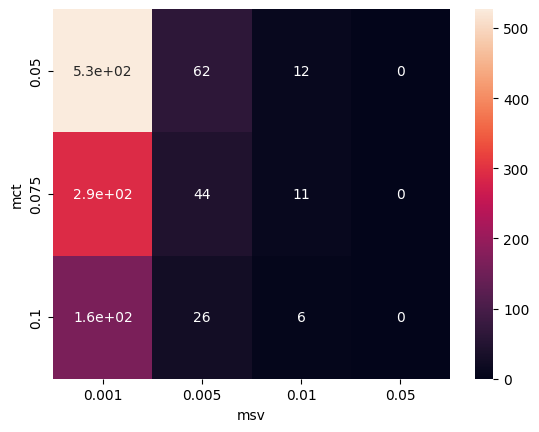

In [29]:
import seaborn as sns
k= pd.DataFrame({'msv': msv, 'mct': mct, 'num_rules': num_rules})

sns.heatmap(k.pivot('mct','msv','num_rules'),annot=True)

In [31]:
# minimum support = 0.005

In [32]:
rules=get_rules(0.005,0)
rules.sort_values(by='confidence',ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1,(bottled beer),(whole milk),0.049500,0.155500,0.007875,0.159091,1.023093,0.000178,1.004270
19,(frankfurter),(other vegetables),0.037375,0.123750,0.005750,0.153846,1.243201,0.001125,1.035568
21,(frankfurter),(whole milk),0.037375,0.155500,0.005625,0.150502,0.967856,-0.000187,0.994116
23,(newspapers),(whole milk),0.040250,0.155500,0.006000,0.149068,0.958639,-0.000259,0.992442
67,(sausage),(whole milk),0.058125,0.155500,0.008250,0.141935,0.912768,-0.000788,0.984192
...,...,...,...,...,...,...,...,...,...
70,(whole milk),(shopping bags),0.155500,0.047375,0.005750,0.036977,0.780528,-0.001617,0.989203
20,(whole milk),(frankfurter),0.155500,0.037375,0.005625,0.036174,0.967856,-0.000187,0.998754
43,(whole milk),(pastry),0.155500,0.052375,0.005375,0.034566,0.659970,-0.002769,0.981553
16,(whole milk),(domestic eggs),0.155500,0.038250,0.005125,0.032958,0.861652,-0.000823,0.994528


### rule with highest confidence
### (bottled beer)	(whole milk)	
### confidence is 0.159

In [57]:
from sklearn.model_selection import train_test_split


In [54]:
import os

In [51]:
image_path='Cropped'

In [60]:
imgs=[]
classes=[]
for i,name in enumerate(os.listdir(image_path)):
    path = os.path.join(image_path,name)
    if os.path.isdir(path):
        files = os.listdir(path)
        images = [file for file in files if file.lower().endswith(('.jpg'))] 
        for image in images:
            src_path = os.path.join(path, image)
            img = cv2.imread(src_path)
            img= cv2.resize(img,(32,32))
            imgs.append(img)
            classes.append(i)
imgs=np.array(imgs)
classes=np.array(classes)

classes=to_categorical(classes,num_classes=4)
x_train,x_test,y_train,y_test=train_test_split(imgs,classes,random_state=42,test_size=0.2,stratify=classes)

In [61]:


print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (582, 32, 32, 3)
582 train samples
146 test samples


In [62]:
model = Sequential()
model.add(Conv2D(8,(3,3),activation='relu', input_shape=x_train[0].shape))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(16,activation='relu'))
model.add(Dense(4,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 8)         224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1800)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                28816     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 68        
Total params: 29,108
Trainable params: 29,108
Non-trainable params: 0
_________________________________________________________________


In [63]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [64]:
model.fit(x_train, y_train, batch_size=10, epochs=20, validation_data=(x_test,y_test))

Train on 582 samples, validate on 146 samples
Epoch 1/20
582/582 [==============================] - 1s 2ms/sample - loss: 5.6276 - accuracy: 0.2405 - val_loss: 1.3863 - val_accuracy: 0.2329
Epoch 2/20
582/582 [==============================] - 0s 521us/sample - loss: 1.3866 - accuracy: 0.2216 - val_loss: 1.3863 - val_accuracy: 0.2740
Epoch 3/20
582/582 [==============================] - 0s 487us/sample - loss: 1.3861 - accuracy: 0.2320 - val_loss: 1.3863 - val_accuracy: 0.2740
Epoch 4/20
582/582 [==============================] - 0s 464us/sample - loss: 1.3852 - accuracy: 0.2680 - val_loss: 1.3869 - val_accuracy: 0.2740
Epoch 5/20
582/582 [==============================] - 0s 473us/sample - loss: 1.3743 - accuracy: 0.2680 - val_loss: 1.3929 - val_accuracy: 0.2740
Epoch 6/20
582/582 [==============================] - 0s 494us/sample - loss: 1.3769 - accuracy: 0.2680 - val_loss: 1.3857 - val_accuracy: 0.2740
Epoch 7/20
582/582 [==============================] - 0s 524us/sample - loss: 1.

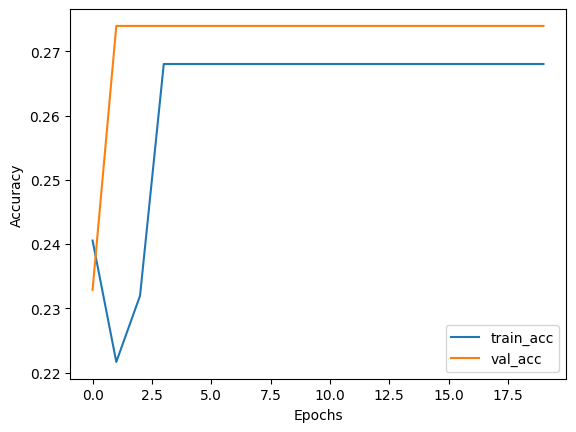

In [66]:
plt.plot(model.history.history['accuracy'], label='train_acc')
plt.plot(model.history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

### model underfit

In [67]:
#916434471

In [68]:
#(a) Train the CNN using 2 other filter sizes: 5 × 5 and 7 × 7 for the convolution layer (i) with all
#other parameters unchanged

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 8)         608       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                25104     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
Total params: 25,780
Trainable params: 25,780
Non-trainable params: 0
_________________________________________________________________
Train on 582 samples, validate on 146 samples
Epoch 1/20
582/582 [==============================] - 1s 2ms/sample - 

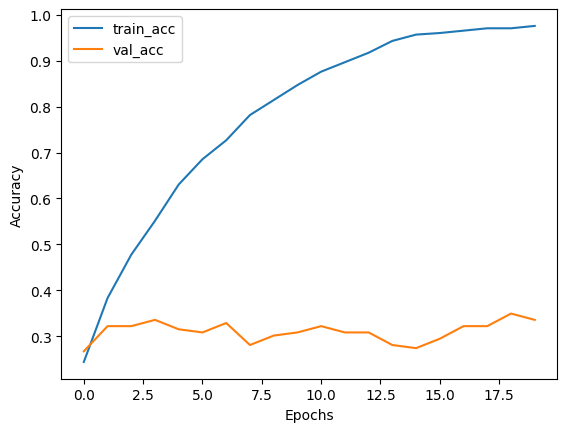

In [69]:
model = Sequential()
model.add(Conv2D(8,(5,5),activation='relu', input_shape=x_train[0].shape))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(16,activation='relu'))
model.add(Dense(4,activation='softmax'))

model.summary()

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=10, epochs=20, validation_data=(x_test,y_test))

plt.plot(model.history.history['accuracy'], label='train_acc')
plt.plot(model.history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

### model over fits

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 8)         1184      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 8)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1352)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                21648     
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 68        
Total params: 22,900
Trainable params: 22,900
Non-trainable params: 0
_________________________________________________________________
Train on 582 samples, validate on 146 samples
Epoch 1/20
582/582 [==============================] - 1s 2ms/sample - 

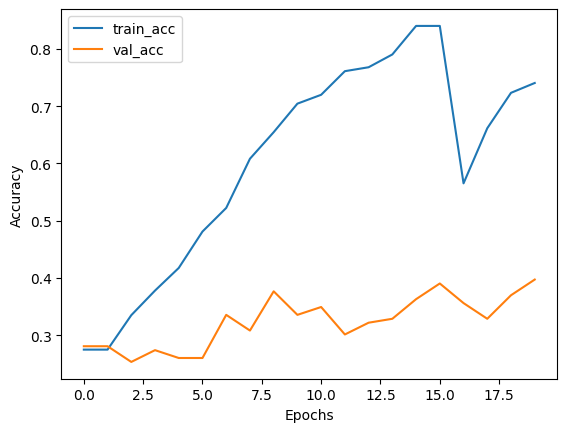

In [70]:

model = Sequential()
model.add(Conv2D(8,(7,7),activation='relu', input_shape=x_train[0].shape))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(16,activation='relu'))
model.add(Dense(4,activation='softmax'))

model.summary()

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=10, epochs=20, validation_data=(x_test,y_test))

plt.plot(model.history.history['accuracy'], label='train_acc')
plt.plot(model.history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

### model overfitted

In [ ]:
Reference : 
    https://rasbt.github.io/mlxtend/
        https://seaborn.pydata.org/generated/seaborn.heatmap.html
            https://www.kaggle.com/code/yassineghouzam/introduction-to-cnn-keras-0-997-top-6